<a href="https://colab.research.google.com/github/AshikaKannan/AshikaKannan/blob/main/Higher_Studies_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 23.1 MB/s eta 0:00:00


In [12]:
!pip install matplotlib


    Student_ID  Name             College_Name  Overall_Probability  \
131     ST0009  Yash               IIT Bombay                  1.3   
133     ST0009  Yash                      NUS                  1.3   
134     ST0009  Yash  University of Melbourne                  1.3   
126     ST0009  Yash    University of Chicago                  1.1   
130     ST0009  Yash          Anna University                  1.1   
132     ST0009  Yash                IIT Delhi                  1.0   
125     ST0009  Yash                  Caltech                  0.8   
127     ST0009  Yash     Princeton University                  0.8   
120     ST0009  Yash       Harvard University                  0.5   
121     ST0009  Yash      Stanford University                  0.5   
122     ST0009  Yash                      MIT                  0.5   
123     ST0009  Yash     University of Oxford                  0.5   
124     ST0009  Yash  University of Cambridge                  0.5   
128     ST0009  Yash

<ipython-input-16-a0f557d9b7b6>:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_recommendations_for_student, x='College_Name', y='Overall_Probability', palette='viridis')


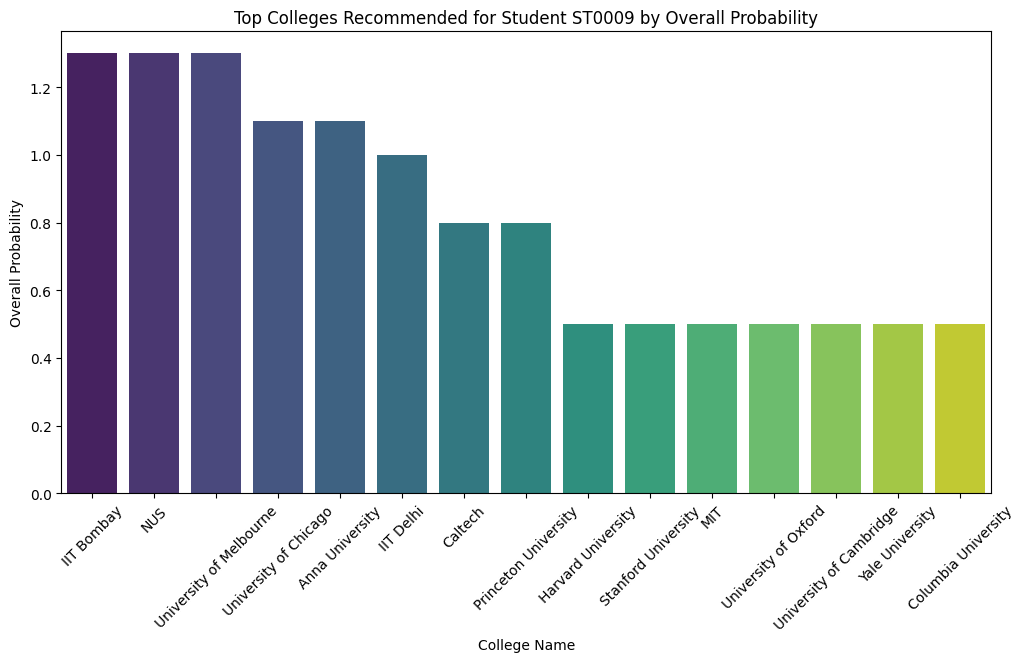

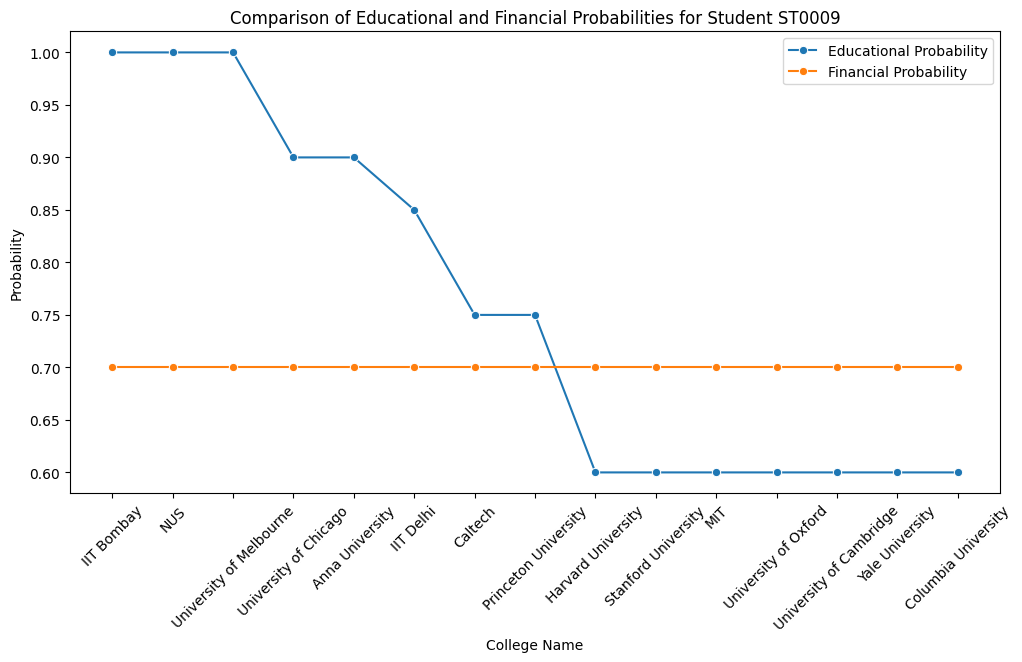

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:48:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


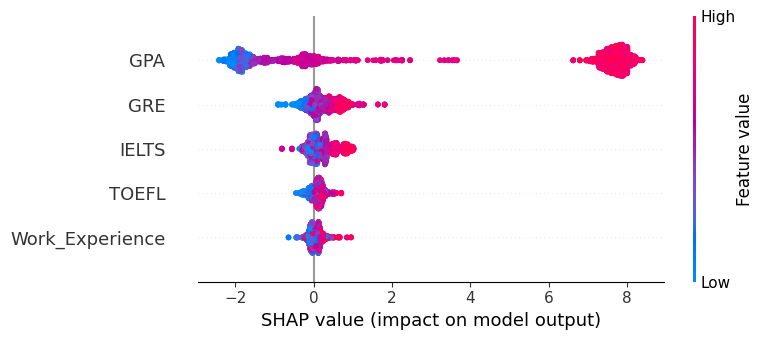

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import shap

# Load the datasets
students_df = pd.read_csv('students.csv')
colleges_df = pd.read_csv('colleges.csv')

# Create a complete dataset for all students and colleges using cross join
student_college = pd.merge(students_df, colleges_df, how='cross')

# Feature engineering for calculating probabilities for all colleges
def calculate_probabilities(row):
    base_prob = 0.5  # Base acceptance probability

    # Increase probability based on GRE
    if row['GRE'] >= row['Minimum_GRE']:
        base_prob += 0.3

    # Increase probability based on GPA
    if row['GPA'] >= row['Minimum_GPA']:
        base_prob += 0.3

    # Increase probability based on TOEFL
    if row['TOEFL'] >= row['Minimum_TOEFL']:
        base_prob += 0.2

    # Check for scholarships
    if row['Available_Scholarships'] and row['Scholarship_Availability']:
        base_prob += 0.2

    # Check course availability
    courses_offered = row['Available_Courses'].split(', ')
    if row['Preferred_Course'] in courses_offered:
        base_prob += 0.3

    return base_prob

# Apply the function to calculate probabilities for all college options
student_college['Overall_Probability'] = student_college.apply(calculate_probabilities, axis=1)

# Function to calculate financial probability based on affordability rating
def financial_probability(row):
    if row['Financial_Affordability_Rating'] == 'High':
        return 0.9
    elif row['Financial_Affordability_Rating'] == 'Medium':
        return 0.7
    else:
        return 0.4

# Apply financial probability calculation
student_college['Financial_Probability'] = student_college.apply(financial_probability, axis=1)

# Educational probability
student_college['Educational_Probability'] = (student_college['Overall_Probability'] + student_college['Financial_Probability']) / 2

# Function to get recommendations for a specific student
def get_recommendations(student_id):
    recommendations = student_college[student_college['Student_ID'] == student_id][
        ['Student_ID', 'Name', 'College_Name', 'Overall_Probability',
         'Financial_Probability', 'Educational_Probability']]

    # Sort by Overall Probability and get top recommendations
    top_recommendations = recommendations.sort_values(by='Overall_Probability', ascending=False)

    return top_recommendations

# Example: Get recommendations for a specific student
student_id_to_check = 'ST0009'  # Replace with the ID of the student you want to check
top_recommendations_for_student = get_recommendations(student_id_to_check)

# Display top recommendations for the specific student
print(top_recommendations_for_student)

# Visualizations for the specific student's recommendations
plt.figure(figsize=(12, 6))
sns.barplot(data=top_recommendations_for_student, x='College_Name', y='Overall_Probability', palette='viridis')
plt.title(f'Top Colleges Recommended for Student {student_id_to_check} by Overall Probability')
plt.xticks(rotation=45)
plt.ylabel('Overall Probability')
plt.xlabel('College Name')
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=top_recommendations_for_student, x='College_Name', y='Educational_Probability', marker='o', label='Educational Probability')
sns.lineplot(data=top_recommendations_for_student, x='College_Name', y='Financial_Probability', marker='o', label='Financial Probability')
plt.title(f'Comparison of Educational and Financial Probabilities for Student {student_id_to_check}')
plt.xticks(rotation=45)
plt.ylabel('Probability')
plt.xlabel('College Name')
plt.legend()
plt.show()

# SHAP Analysis (Optional)
X = student_college[['GRE', 'TOEFL', 'IELTS', 'GPA', 'Work_Experience']]
y = np.where(student_college['Overall_Probability'] > 0.7, 1, 0)  # Binary target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the feature importance
shap.summary_plot(shap_values, X_test)
